# 01 - EDA and relationships

This notebook explores the dataset and looks for the relationship between classifications and Alzheimer's diagnosis with demographics, severity indices, daily activities, and brain volumes using Pearson correlation, ANOVA and Tukey analyses.

**Dataset:** NACC Alzheimers Dataset (Brian Jing, Kaggle)  


In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path(__file__).parent.parent if "__file__" in globals() else Path("..").resolve()))

import pandas as pd
import matplotlib.pyplot as plt
import os
from src.preprocessing import (
    read_data,
    convert_numeric_columns,
    handle_missing_values,
    save_dataframe,
    summary_statistics
)
from src.analysis import (
    pearson_correlation, severity_analysis,
    compute_group_means_for_plot, anova,
    tukey, tukey_significant_summary,
    daily_activity_columns, 
    brain_volume_columns, compute_group_means,
    run_chi_square_test, filter_significant_results
)
from src.config import (
    correlation_cols, demo_cols, 
    severity_cols, activity_cols, 
    volume_groups, brain_cols, 
    chi_square_alpha)
from src.visualization import plot_group_means, plot_bar_side_by_side


In [2]:
# Path
project_root = Path(__file__).parent.parent if "__file__" in globals() else Path("..").resolve()

tables_dir = project_root / "reports" / "tables"
figures_dir = project_root / "reports" / "figures"

# Create directories
tables_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)


In [3]:
# Load dataset
DATA_PATH = Path("../data/raw/nacc_alzheimers_dataset.csv")
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (2700, 57)


,id,diagnosis,age,educ,female,height,weight,bpsys,bpdias,hrate,...,ltempcor,rtempcor,lcac,rcac,lent,rent,lparhip,rparhip,lposcin,rposcin
0,S060833,0,74,12,0,65.0,233,148,100,72,...,57.9700,58.5800,3.3200,1.9800,3.2000,3.7300,3.5800,3.6800,3.7500,3.4400
1,S932623,0,56,16,1,62.0,110,110,75,60,...,60.3437,58.7091,3.7060,2.1906,3.6755,4.6463,3.5534,4.1952,3.9091,4.2362
2,S755478,0,77,18,1,65.0,137,144,60,64,...,58.8357,51.5753,3.2748,1.7054,3.6207,2.5787,3.7515,3.6703,3.8686,3.7062
3,S852291,0,74,20,1,62.0,112,120,60,72,...,54.2100,56.1600,2.6300,1.4400,4.3300,4.1000,3.6000,3.9200,3.4500,3.5300
4,S011143,1,75,14,0,62.0,127,145,61,58,...,57.3215,54.4138,3.8628,1.5277,4.2328,4.4572,3.7079,3.4988,3.1321,2.9051


In [4]:
# EDA
# 1. Convert columns automatically
df = convert_numeric_columns(df, exclude=['id'])

# 2. Handle missing values
df = handle_missing_values(df)

# 3. Save clean df
save_dataframe(df, "../data/processed/nacc_alzheimers_dataset_processed.csv")

# 4. Summary statistics
df_summary = summary_statistics(df)
save_dataframe(df_summary, "../reports/tables/summary_statistics.csv")
df_summary


,diagnosis,age,educ,female,height,weight,bpsys,bpdias,hrate,cdrglob,...,ltempcor,rtempcor,lcac,rcac,lent,rent,lparhip,rparhip,lposcin,rposcin
count,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,...,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00,2700.00
mean,0.64,70.05,15.29,0.57,65.72,167.27,132.45,74.24,67.13,0.33,...,59.47,56.93,3.33,1.99,4.00,3.81,3.86,3.99,4.09,3.86
std,0.80,11.55,3.39,0.49,3.85,35.77,18.59,9.77,10.78,0.46,...,7.81,7.51,0.80,0.56,0.69,0.71,0.53,0.55,0.70,0.67
min,0.00,21.00,0.00,0.00,51.00,80.00,78.00,32.00,39.00,0.00,...,0.00,0.00,1.41,0.55,0.77,1.35,0.77,1.26,2.03,2.02
25%,0.00,64.00,13.00,0.00,63.00,140.75,120.00,68.00,60.00,0.00,...,54.51,52.19,2.74,1.59,3.56,3.35,3.51,3.61,3.60,3.41
50%,0.00,72.00,16.00,1.00,65.50,164.00,130.00,74.00,66.00,0.00,...,59.37,56.72,3.25,1.97,4.00,3.83,3.85,3.99,4.04,3.83
75%,1.00,78.00,18.00,1.00,68.40,189.00,143.00,80.00,73.00,0.50,...,64.14,61.63,3.86,2.35,4.44,4.27,4.19,4.34,4.50,4.28
max,2.00,100.00,25.00,1.00,78.80,320.00,209.00,118.00,116.00,3.00,...,88.43,87.51,6.94,4.33,6.70,6.62,6.27,6.31,7.20,6.89


## Relationship between classifications - Pearson correlation

In [5]:
corr_matrix = pearson_correlation(df, correlation_cols)
print("Correlation matrix:\n", corr_matrix)


Correlation matrix:
            diagnosis   cdrglob   naccgds
diagnosis   1.000000  0.754725  0.234902
cdrglob     0.754725  1.000000  0.216806
naccgds     0.234902  0.216806  1.000000


## Relationship between diagnosis and demographics - Pearson correlation

In [6]:
demo_corr = pearson_correlation(df, ['diagnosis'] + demo_cols)
print("\nDiagnosis vs Demographics:\n", demo_corr['diagnosis'])



Diagnosis vs Demographics:
 diagnosis    1.000000
age          0.214070
educ        -0.121553
female      -0.172308
Name: diagnosis, dtype: float64


## Relationship between diagnosis and severity indices - ANOVA and Tukey analyses

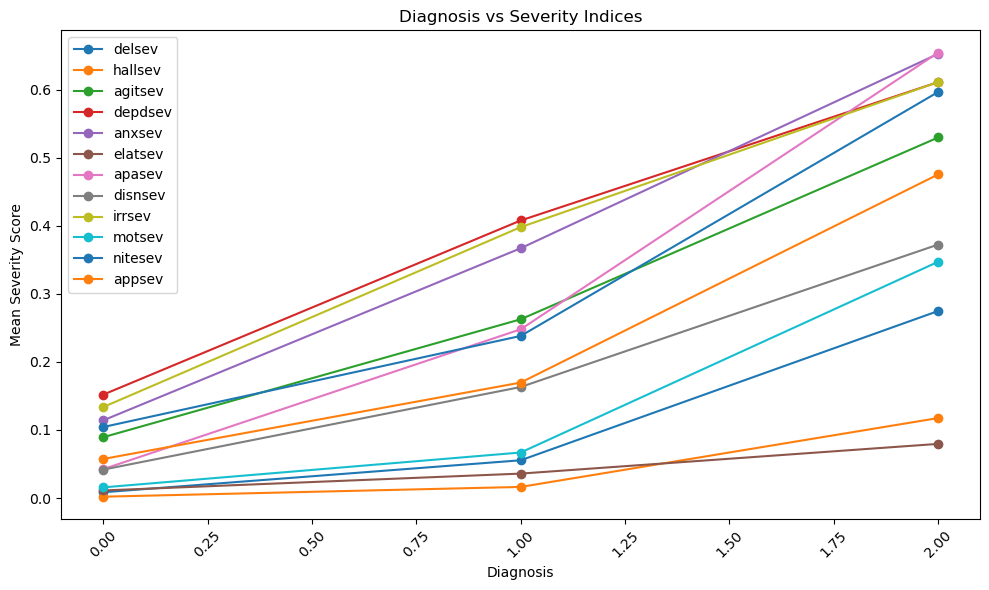

In [7]:
severity_cols = severity_analysis(df)
severity_means = compute_group_means_for_plot(df, 'diagnosis', severity_cols)

# Plot
plot_group_means(severity_means,
                 group_labels='diagnosis',
                 title="Diagnosis vs Severity Indices",
                 xlabel="Diagnosis",
                 ylabel="Mean Severity Score",
                 save_path="../reports/figures/severity_indices_plot.png")

In [8]:
# ANOVA
anova_severity = anova(df, dependent_columns=severity_cols, covariates=['diagnosis'])

# Display p-values sorted
df_anova = pd.DataFrame([
    {"measure": dep, "F_statistic": res["F_statistic"], "p_value": res["p_value"]}
    for dep, res in anova_severity.items()
])
df_anova.sort_values('p_value', inplace=True)
df_anova


,measure,F_statistic,p_value
6,apasev,275.695897,1.143174e-109
4,anxsev,162.170986,3.114676e-67
9,motsev,147.174757,2.168161e-61
11,appsev,141.567273,3.434656e-59
10,nitesev,132.185376,1.717666e-55
8,irrsev,132.150626,1.772896e-55
2,agitsev,127.366574,1.393148e-53
3,depdsev,123.084328,7.010144e-52
0,delsev,108.665280,4.096099e-46
7,disnsev,106.449727,3.187838e-45


In [9]:
# Save
anova_severity_df = pd.DataFrame([
    {"measure": dep, **res}
    for dep, res in anova_severity.items()
])

file_path = os.path.join(tables_dir, "anova_severity.csv")
anova_severity_df.to_csv(file_path, index=False)

file_path = os.path.join(tables_dir, "anova_severity.csv")
anova_severity_df.to_csv(file_path, index=False)


In [10]:
# Tukey post-hoc test for significant severity indices
tukey_severity = tukey(df, group_col='diagnosis', measure_cols=severity_cols)

for measure, tukey_obj in tukey_severity.items():
    summary_df = pd.DataFrame(
        tukey_obj.summary().data[1:], 
        columns=tukey_obj.summary().data[0]
    )
    summary_df.to_csv(
        os.path.join(tables_dir, f"tukey_severity_{measure}.csv"),
        index=False
    )
    
tukey_severity


{'delsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f8928280>,
 'hallsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f8929690>,
 'agitsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f91420e0>,
 'depdsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f888bf10>,
 'anxsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f91433d0>,
 'elatsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9143700>,
 'apasev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f1605150>,
 'disnsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9143a60>,
 'irrsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9236200>,
 'motsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9237070>,
 'nitesev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f92373d0>,
 'appsev': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9237700>

In [11]:
df_tukey_significant = tukey_significant_summary(
    df,
    group_col="diagnosis",
    measure_cols=severity_cols,
    variable_type="severity"
)[0]

df_tukey_significant.to_csv(
    os.path.join(tables_dir, "tukey_severity_significant.csv"),
    index=False
)

print("Total significant comparisons:", len(df_tukey_significant))
print ("First 5 significant comparisons:")
df_tukey_significant.head(5)

Total significant comparisons: 34
First 5 significant comparisons:


,group1,group2,meandiff,p-adj,lower,upper,reject,measure
5,0,1,0.1733,0.0,0.1104,0.2363,True,agitsev
6,0,2,0.4405,0.0,0.3752,0.5059,True,agitsev
7,1,2,0.2672,0.0,0.1899,0.3445,True,agitsev
11,0,1,0.2530,0.0,0.1838,0.3222,True,anxsev
12,0,2,0.5387,0.0,0.4669,0.6106,True,anxsev


## Relationship between diagnosis and daily activities - ANOVA and Tukey analyses

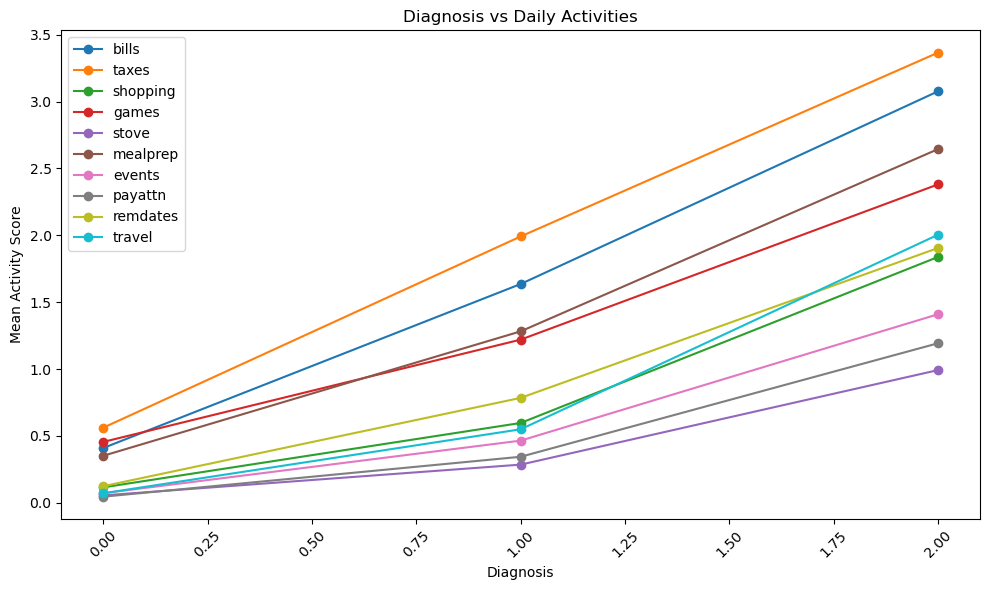

In [12]:
daily_activity_cols = daily_activity_columns(df)
daily_means = compute_group_means_for_plot(df, group_col='diagnosis', measure_cols=activity_cols)

# Group labels
group_labels = sorted(df['diagnosis'].unique())

# Plot
plot_group_means(daily_means, group_labels,
                 title="Diagnosis vs Daily Activities",
                 xlabel="Diagnosis",
                 ylabel="Mean Activity Score",
                 save_path="../reports/figures/daily_activities_plot.png")


In [13]:
# ANOVA
anova_activity = anova(df, dependent_columns=activity_cols, covariates=['diagnosis'])

# Display p-values sorted
df_anova = pd.DataFrame([
    {"measure": dep, "F_statistic": res["F_statistic"], "p_value": res["p_value"]}
    for dep, res in anova_activity.items()
])
df_anova.sort_values('p_value', inplace=True)
df_anova

,measure,F_statistic,p_value
9,travel,1074.201789,0.000000e+00
8,remdates,944.496511,1.259014e-311
7,payattn,550.690128,2.847477e-201
6,events,421.606689,4.750705e-160
2,shopping,366.480329,1.605287e-141
0,bills,345.124580,3.500119e-134
1,taxes,325.054199,3.355531e-127
5,mealprep,239.300817,2.140783e-96
4,stove,175.250279,2.784519e-72
3,games,156.429492,5.290231e-65


In [14]:
# Save
anova_activity_df = pd.DataFrame([
    {"measure": dep, **res}
    for dep, res in anova_severity.items()
])

file_path = os.path.join(tables_dir, "anova_severity.csv")
anova_activity_df.to_csv(file_path, index=False)

file_path = os.path.join(tables_dir, "anova_activity.csv")
anova_activity_df.to_csv(file_path, index=False)

In [15]:
# Tukey post-hoc test for significant daily activities
tukey_activity = tukey(df, group_col='diagnosis', measure_cols=activity_cols)

for measure, tukey_obj in tukey_activity.items():
    summary_df = pd.DataFrame(
        tukey_obj.summary().data[1:], 
        columns=tukey_obj.summary().data[0]
    )
    summary_df.to_csv(
        os.path.join(tables_dir, f"tukey_activity_{measure}.csv"),
        index=False
    )
tukey_activity


{'bills': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9236650>,
 'taxes': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9235ae0>,
 'shopping': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f95e6200>,
 'games': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f95e5600>,
 'stove': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f85dfbb0>,
 'mealprep': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f85dedd0>,
 'events': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f87f6dd0>,
 'payattn': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f87f7af0>,
 'remdates': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f87f7df0>,
 'travel': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f87f7a60>}

In [16]:
df_tukey_significant = tukey_significant_summary(
    df,
    group_col="diagnosis",
    measure_cols=activity_cols,
    variable_type="activity"
)[0]

df_tukey_significant.to_csv(
    os.path.join(tables_dir, "tukey_activity_significant.csv"),
    index=False
)

print("Total significant comparisons:", len(df_tukey_significant))
print ("First 5 significant comparisons:")
df_tukey_significant.head(5)


Total significant comparisons: 30
First 5 significant comparisons:


,group1,group2,meandiff,p-adj,lower,upper,reject,measure
0,0,1,1.2268,0.0,0.9924,1.4613,True,bills
1,0,2,2.6684,0.0,2.4250,2.9118,True,bills
2,1,2,1.4415,0.0,1.1538,1.7293,True,bills
18,0,1,0.3932,0.0,0.2890,0.4974,True,events
19,0,2,1.3388,0.0,1.2306,1.4469,True,events


## Relationship between diagnosis and brain volumes - ANOVA and Tukey analyses

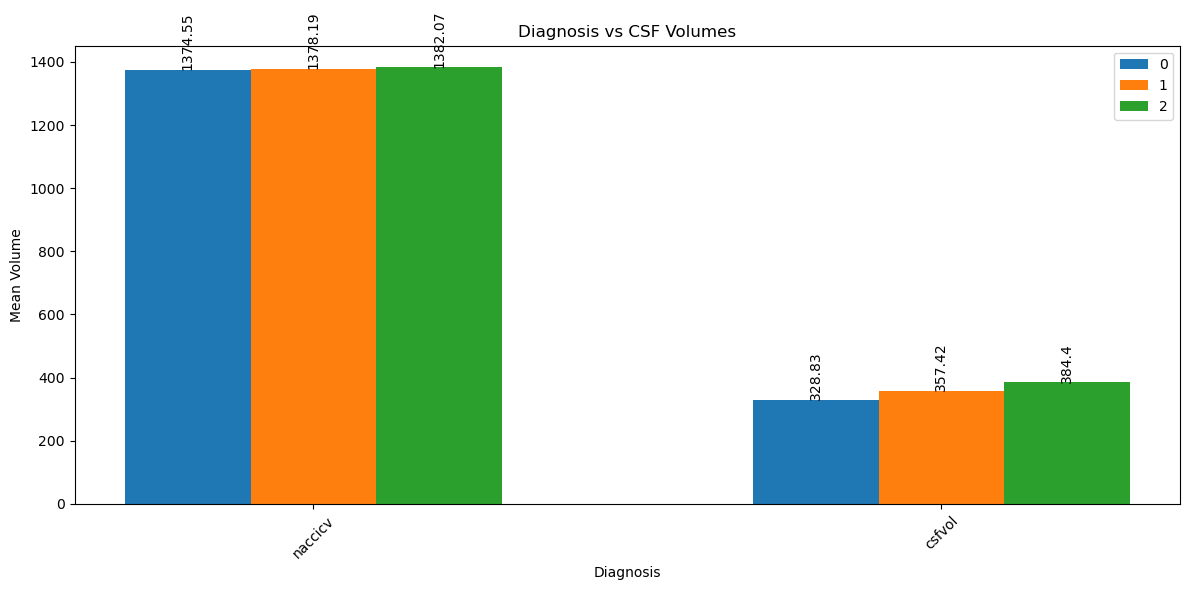

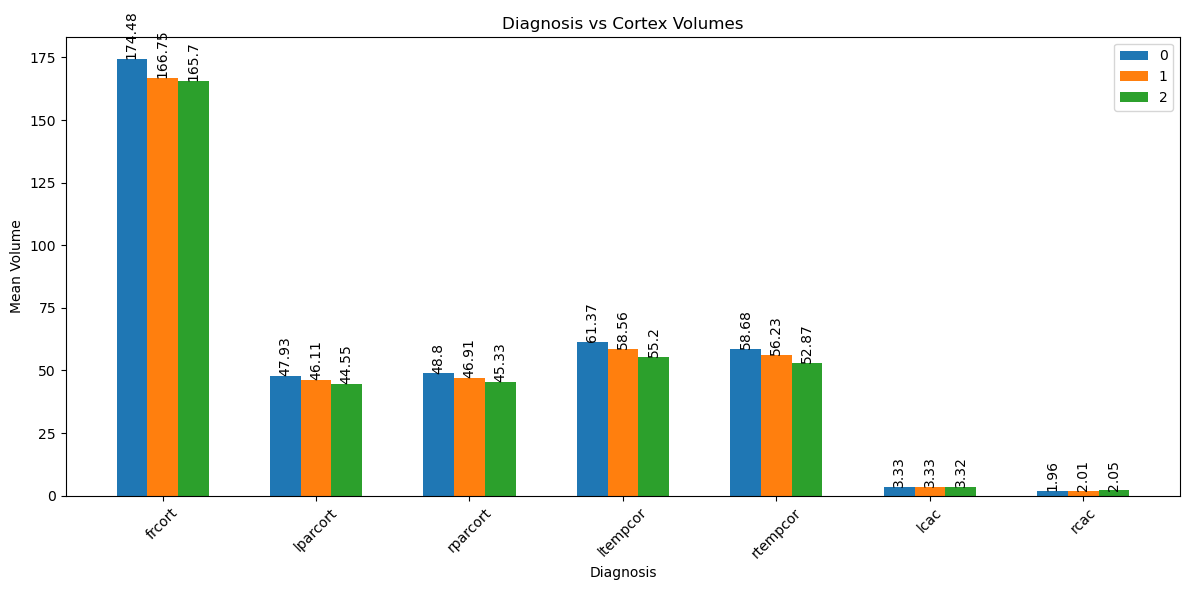

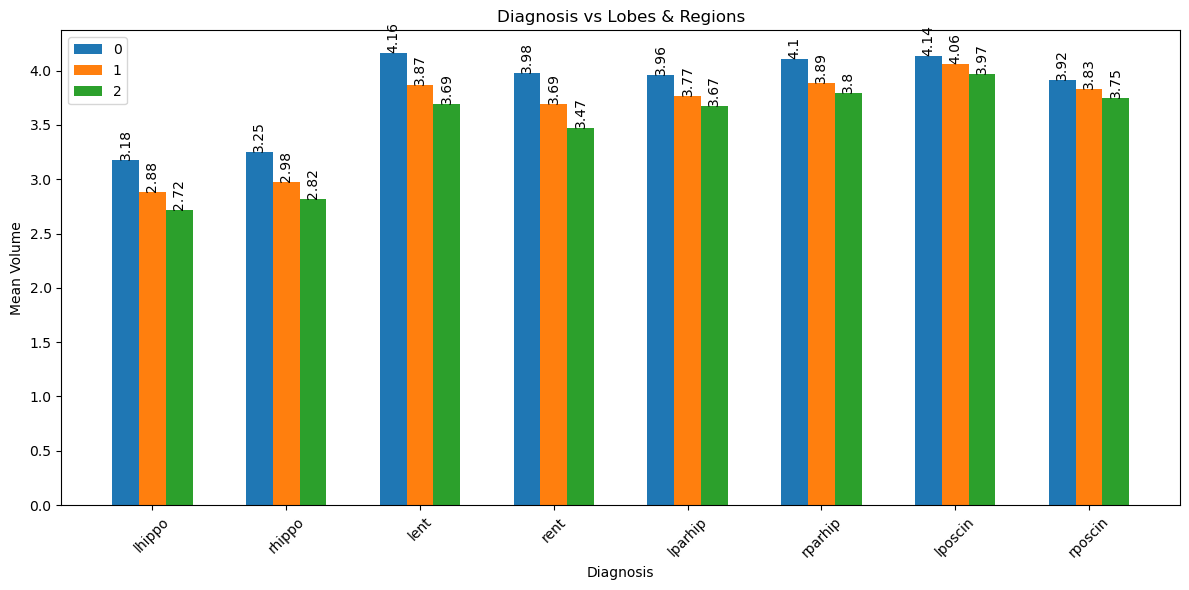

In [17]:
volume_cols = brain_volume_columns(df)
volume_means = compute_group_means(df, group_col='diagnosis', value_cols=volume_cols)

# Plot
for region_name, cols in volume_groups.items():
    # Compute group means
    means_dict = compute_group_means(df, 'diagnosis', cols)
    df_means = pd.DataFrame(means_dict, index=group_labels).T  # rows=measure, cols=diagnosis
   
    plot_bar_side_by_side(df_means, group_labels,
                          title=f"Diagnosis vs {region_name}",
                          xlabel="Diagnosis",
                          ylabel="Mean Volume", 
                          save_path=os.path.join( figures_dir, f"{region_name.replace(' ','_').lower()}_barplot.png"))


In [18]:
# ANOVA
anova_brain = anova(df, dependent_columns=brain_cols, covariates=['diagnosis'])

# Display p-values sorted
df_anova = pd.DataFrame([
    {"measure": dep, "F_statistic": res["F_statistic"], "p_value": res["p_value"]}
    for dep, res in anova_brain.items()
])
df_anova.sort_values('p_value', inplace=True)
df_anova


,measure,F_statistic,p_value
7,lhippo,247.127052,2.825055e-99
8,rhippo,213.245700,1.048316e-86
0,csfvol,190.440020,4.320693e-78
4,ltempcor,146.911758,2.748403e-61
5,rtempcor,137.630631,1.216640e-57
10,rent,127.786687,9.491041e-54
9,lent,116.507585,2.944001e-49
12,rparhip,82.891123,1.158546e-35
11,lparhip,73.882471,5.773023e-32
3,rparcort,61.978366,4.823665e-27


In [19]:
# Tukey post-hoc test for significant brain volumes
tukey_brain = tukey(df, group_col='diagnosis', measure_cols=brain_cols)
tukey_brain


{'csfvol': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9247e50>,
 'frcort': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9244ca0>,
 'lparcort': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f92466b0>,
 'rparcort': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f936b820>,
 'ltempcor': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f936bb20>,
 'rtempcor': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f936bf10>,
 'rcac': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f936ba90>,
 'lhippo': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f94274f0>,
 'rhippo': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9427820>,
 'lent': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9427af0>,
 'rent': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9427760>,
 'lparhip': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x1e2f9bf2440>,
 

In [20]:
df_tukey_significant = tukey_significant_summary(
    df,
    group_col="diagnosis",
    measure_cols=brain_cols,
    variable_type="brain"
)[0]

print("Total significant comparisons:", len(df_tukey_significant))
print ("First 5 significant comparisons:")
df_tukey_significant.head(5)

Total significant comparisons: 40
First 5 significant comparisons:


,group1,group2,meandiff,p-adj,lower,upper,reject,measure
0,0,1,28.5920,0.0,21.9300,35.2539,True,csfvol
1,0,2,55.5713,0.0,48.6559,62.4866,True,csfvol
2,1,2,26.9793,0.0,18.8025,35.1561,True,csfvol
3,0,1,-7.7344,0.0,-10.3528,-5.1160,True,frcort
4,0,2,-8.7848,0.0,-11.5028,-6.0668,True,frcort


## Chi-Square Analysis of Variables Selected via Tukey Post-Hoc

In [21]:
all_features = brain_cols + severity_cols

# Chi-square
chi_results = run_chi_square_test(
    df=df,
    feature_cols=all_features,
    label_col="diagnosis"
)

# Split results
volume_results = [
    (var, p) for var, p in chi_results
    if var in brain_cols
]

severity_results = [
    (var, p) for var, p in chi_results
    if var in severity_cols
]

# Filter by significance
significant_volumes = filter_significant_results(
    volume_results,
    chi_square_alpha
)

significant_severity = filter_significant_results(
    severity_results,
    chi_square_alpha
)


In [22]:
# Results
significant_volumes = filter_significant_results(
    volume_results, chi_square_alpha,
    save_path="../reports/tables/chi_square_significant_brain_volumes.csv"
)

significant_severity = filter_significant_results(
    severity_results, chi_square_alpha,
    save_path="../reports/tables/chi_square_significant_severity_indices.csv"
)

print("Significant brain volume variables:")
for variable, p_value in significant_volumes:
    print(f"Variable: {variable}, p-value: {p_value:.3e}")

print("\nSignificant severity index variables:")
for variable, p_value in significant_severity:
    print(f"Variable: {variable}, p-value: {p_value:.3e}")


Significant brain volume variables:
Variable: lhippo, p-value: 4.357e-05
Variable: rhippo, p-value: 2.186e-06
Variable: lent, p-value: 3.801e-03
Variable: rent, p-value: 3.814e-03
Variable: lparhip, p-value: 3.069e-03
Variable: rparhip, p-value: 3.627e-02

Significant severity index variables:
Variable: delsev, p-value: 8.449e-48
Variable: hallsev, p-value: 2.453e-25
Variable: agitsev, p-value: 2.201e-54
Variable: depdsev, p-value: 1.747e-48
Variable: anxsev, p-value: 6.685e-63
Variable: elatsev, p-value: 8.049e-08
Variable: apasev, p-value: 2.075e-106
Variable: disnsev, p-value: 1.173e-47
Variable: irrsev, p-value: 9.514e-57
Variable: motsev, p-value: 6.011e-58
Variable: nitesev, p-value: 5.386e-50
Variable: appsev, p-value: 7.187e-56


## Conclusions

- **Significant severity indices:** `delsev`, `hallsev`, `agitsev`, `depdsev`, `anxsev`, `elatsev`, `apasev`, `disnsev`, `irrsev`, `motsev`, `nitesev`, `appsev` show statistically significant differences between diagnostic groups.

- **Significant brain volume variables:** `lhippo`, `rhippo`, `lent`, `rent`, `lparhip`, `rparhip` are significantly associated with diagnosis.

- **Significant daily activity variables:** `bills`, `taxes`, `shopping, games`, `stove`, `mealprep`, `events`, `payattn`, `remdates`, `travel` differ significantly across diagnostic groups, highlighting functional impacts.

Key severity indices, brain volumes, and daily activities have been identified that reliably differentiate diagnostic groups, highlighting the most relevant variables for understanding Alzheimer's-related changes in this dataset.

